# PCA for Exploratory Analysis & Outlier Detection
We will extract all relevant datasets from all HDF5 files and convert them into a readable Pandas dataframe. We will also do some preliminary data cleaning and PCA analysis. Everything will be outputted as *.parquet* files. This dramatically reduces the memory usage in the outlier detector scripts.

In [1]:
import os
import random

import h5py
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## PCA for Exploratory Analysis

In [2]:
'''Optional: load the pre-computed scaled data from a .parquet file'''
scaled_data = pd.read_parquet('input_standard_scaled.parquet', engine='pyarrow')
scaled_data

,RH_25,RH_50,RH_75,RH_85,RH_95,RH_100,channel,degrade_flag,delta_time,digital_elevation_model,...,zcross_amp,zcross_localenergy,RH_25 Z Score,RH_50 Z Score,RH_75 Z Score,RH_85 Z Score,RH_95 Z Score,RH_100 Z Score,RH_95_minus_50,Missingness
0,-0.261052,-0.219977,-0.205986,-0.204688,-0.209075,-0.235969,-1.160313,-0.225547,-1.733653,-1.193618,...,0.185156,-0.211920,-0.261052,-0.219977,-0.205986,-0.204688,-0.209075,-0.235969,-0.157817,-0.842991
1,-0.344765,-0.238197,-0.205986,-0.198081,-0.197517,-0.212452,-1.160313,-0.225547,-1.733653,-1.193618,...,0.208783,-0.188663,-0.344765,-0.238197,-0.205986,-0.198081,-0.197517,-0.212452,-0.118490,-0.842991
2,-0.296300,-0.238197,-0.219014,-0.216249,-0.219189,-0.241195,-1.160313,-0.225547,-1.733653,-1.193618,...,0.207195,-0.150200,-0.296300,-0.238197,-0.219014,-0.216249,-0.219189,-0.241195,-0.157817,-0.842991
3,-0.296300,-0.238197,-0.213431,-0.209643,-0.209075,-0.221597,-1.160313,-0.225547,-1.733653,-1.193618,...,0.231784,-0.122365,-0.296300,-0.238197,-0.213431,-0.209643,-0.209075,-0.221597,-0.139465,-0.842991
4,-0.309517,-0.227785,-0.205986,-0.198081,-0.187403,-0.187628,-1.160313,-0.225547,-1.733653,-1.193618,...,0.270389,-0.049602,-0.309517,-0.227785,-0.205986,-0.198081,-0.187403,-0.187628,-0.110624,-0.842991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11607182,-0.459320,-0.266829,-0.213431,-0.198081,-0.175844,-0.060899,1.733180,-0.225547,1.428969,0.836476,...,2.818989,3.565103,-0.459320,-0.266829,-0.213431,-0.198081,-0.175844,-0.060899,-0.050322,-0.842991
11607183,-0.459320,-0.277240,-0.219014,-0.209643,-0.187403,-0.060899,1.733180,-0.225547,1.428969,0.836477,...,2.961269,3.969460,-0.459320,-0.277240,-0.219014,-0.209643,-0.187403,-0.060899,-0.060809,-0.842991
11607184,-0.476943,-0.277240,-0.213431,-0.198081,-0.175844,-0.041302,1.733180,-0.225547,1.428969,0.836477,...,2.844775,3.569757,-0.476943,-0.277240,-0.213431,-0.198081,-0.175844,-0.041302,-0.039835,-0.842991
11607185,-0.428478,-0.256417,-0.205986,-0.191474,-0.171510,-0.046528,1.733180,-0.225547,1.428969,0.836474,...,2.499454,3.202729,-0.428478,-0.256417,-0.205986,-0.191474,-0.171510,-0.046528,-0.052944,-0.842991


In [4]:
print("Any NaNs?", np.isnan(scaled_data).any())
print("Any Infs?", np.isinf(scaled_data).any())

# Step 1: Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)
print('PCA fitted')

# Step 2: Create a DataFrame for PCA results
n_components = pca_result.shape[1]
col_names = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(pca_result, columns=col_names)

# # Step 3: (Optional) Add PCA results back to the original DataFrame
# complete_with_pca = complete_df.copy()
# complete_with_pca[['PC1', 'PC2', 'PC3']] = pca_df

# Step 4: Print or inspect the results
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
pca_df

# Uncomment the two lines below to write scaled_df to parquet
pca_df.to_parquet("input_pca_standard.parquet", engine="pyarrow", compression="snappy")
print('Successfully wrote to a .parquet file!')


Any NaNs? RH_25             False
RH_50             False
RH_75             False
RH_85             False
RH_95             False
                  ...  
RH_85 Z Score     False
RH_95 Z Score     False
RH_100 Z Score    False
RH_95_minus_50    False
Missingness       False
Length: 85, dtype: bool
Any Infs? RH_25             False
RH_50             False
RH_75             False
RH_85             False
RH_95             False
                  ...  
RH_85 Z Score     False
RH_95 Z Score     False
RH_100 Z Score    False
RH_95_minus_50    False
Missingness       False
Length: 85, dtype: bool
Successfully wrote to a .parquet file!


In [ ]:
'''Optional: load the pre-computed PCA data from a .parquet file'''
pca_df = pd.read_parquet('input_pca_standard.parquet', engine='pyarrow')
pca_df

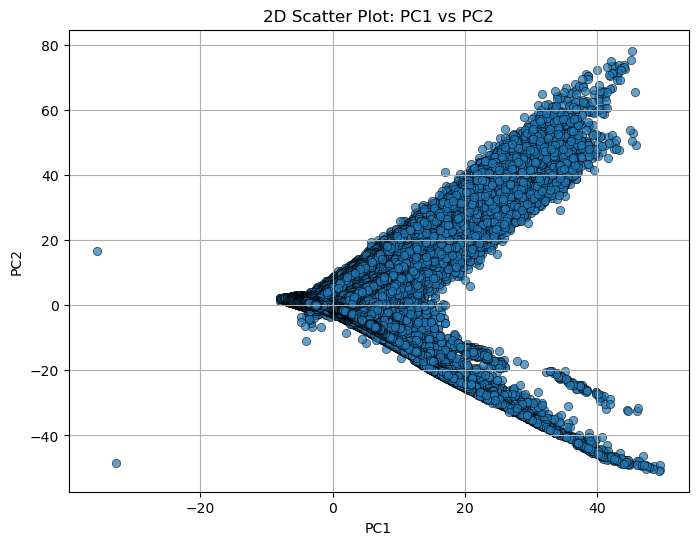

In [5]:
'''2D Visualization'''
import seaborn as sns

# -----------------------------------------------------------------------------
# Assumptions:
# - pca_df: A DataFrame with PCA-transformed data, e.g. columns "PC1", "PC2", "PC3", etc.
# - raw_df: The original data containing key features ("RH_50", "RH_95") and a column 
#           "IsolationForest_Score" which holds the anomaly scores from your Isolation Forest.
# -----------------------------------------------------------------------------

# ---------------------------
# 1. Generate 2D Graph of PC1 & PC2
# ---------------------------
plt.figure(figsize=(8, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.7, edgecolor='k', linewidth=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D Scatter Plot: PC1 vs PC2")
plt.grid(True)
plt.show()

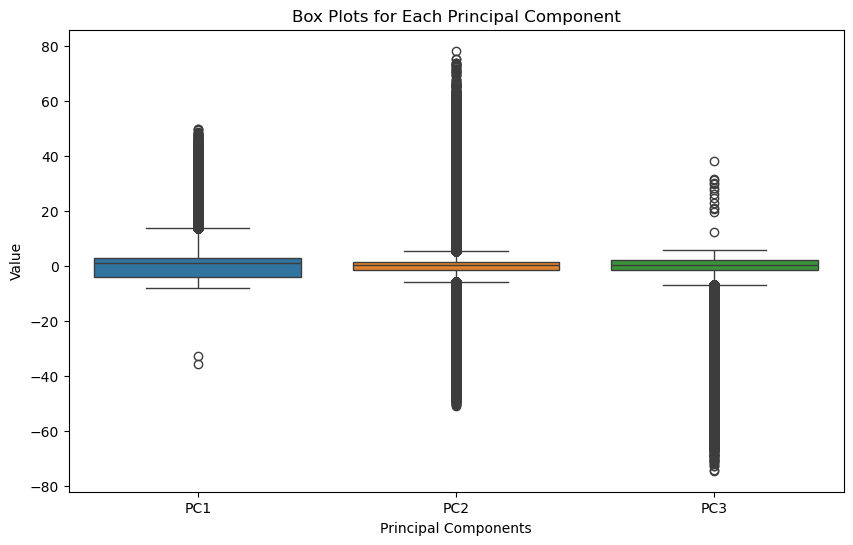

In [6]:
# ---------------------------
# 2. Distribution Box Plots for Each PC
# ---------------------------
# Filter columns that start with "PC" (assuming these are your principal component columns).
pc_columns = [col for col in pca_df.columns if col.startswith("PC")]

plt.figure(figsize=(10, 6))
sns.boxplot(data=pca_df[pc_columns])
plt.title("Box Plots for Each Principal Component")
plt.xlabel("Principal Components")
plt.ylabel("Value")
plt.show()

In [ ]:
'''3D Visualization (Optional, only works for 3 PCs)'''
import plotly.express as px

# Downsample the data if it is very large
n_sample = 500000
if len(pca_df) > n_sample:
    sample_df = pca_df.sample(n=n_sample, random_state=42)
else:
    sample_df = pca_df
print("Created random subset of all points")

fig = px.scatter_3d(
    sample_df,
    x='PC1',
    y='PC2',
    z='PC3',
    title='3D PCA Plot (Sampled Data)',
    labels={
        'PC1': 'Principal Component 1',
        'PC2': 'Principal Component 2',
        'PC3': 'Principal Component 3'
    },
    hover_data=sample_df.columns  # Show all column info on hover
)
fig.show()

## PCA-based Outlier Detection

In [3]:
'''Importing original input'''
raw_df = pd.read_parquet('input_raw.parquet', engine='pyarrow')
raw_df

,File Name,Beam Name,Shot Number,RH_25,RH_50,RH_75,RH_85,RH_95,RH_100,channel,...,zcross_localenergy,RH_25 Z Score,RH_50 Z Score,RH_75 Z Score,RH_85 Z Score,RH_95 Z Score,RH_100 Z Score,RH_50_v_100,RH_95_minus_50,Missingness
0,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050304,-0.78,0.00,0.78,1.19,1.79,2.36,0,...,163.479019,-0.267243,-0.224966,-0.212232,-0.213468,-0.214492,-0.240572,0.000000,1.79,0
1,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050305,-0.97,-0.07,0.78,1.23,1.87,2.54,0,...,178.583328,-0.352941,-0.243600,-0.212232,-0.206578,-0.202634,-0.216597,-0.027559,1.94,0
2,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050306,-0.86,-0.07,0.71,1.12,1.72,2.32,0,...,203.563889,-0.303326,-0.243600,-0.225654,-0.225526,-0.224867,-0.245900,-0.030172,1.79,0
3,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050307,-0.86,-0.07,0.74,1.16,1.79,2.47,0,...,221.641510,-0.303326,-0.243600,-0.219902,-0.218636,-0.214492,-0.225921,-0.028340,1.86,0
4,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050308,-0.89,-0.03,0.78,1.23,1.94,2.73,0,...,268.898804,-0.316857,-0.232952,-0.212232,-0.206578,-0.192258,-0.191289,-0.010989,1.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11607182,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293934,-1.23,-0.18,0.74,1.23,2.02,3.70,5,...,2616.521729,-0.470212,-0.272881,-0.219902,-0.206578,-0.180400,-0.062087,-0.048649,2.20,0
11607183,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293935,-1.23,-0.22,0.71,1.16,1.94,3.70,5,...,2879.136963,-0.470212,-0.283529,-0.225654,-0.218636,-0.192258,-0.062087,-0.059459,2.16,0
11607184,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293936,-1.27,-0.22,0.74,1.23,2.02,3.85,5,...,2619.544189,-0.488253,-0.283529,-0.219902,-0.206578,-0.180400,-0.042108,-0.057143,2.24,0
11607185,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293937,-1.16,-0.14,0.78,1.27,2.05,3.81,5,...,2381.172363,-0.438639,-0.262233,-0.212232,-0.199688,-0.175953,-0.047435,-0.036745,2.19,0


In [4]:
# -------------------------------
# Step 1: Fit PCA and reconstruct the data
# -------------------------------

# Tunable Parameter 1: n_components
#   - You can set this to a fixed number (e.g., 10) or choose it so that a desired amount
#     of variance is explained (e.g., using PCA(n_components=0.95)).
n_components = 3  # <-- Tune this parameter to capture enough variance without overfitting

# Initialize and fit PCA on the scaled data
pca = PCA(n_components=n_components, random_state=42)
pca_transformed = pca.fit_transform(scaled_data)
print("Fit PCA on scaled data")

# Reconstruct the data from the PCA-transformed values
reconstructed_data = pca.inverse_transform(pca_transformed)
print("Reconstructed data after PCA")
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Fit PCA on scaled data
Reconstructed data after PCA
Explained Variance Ratio: [0.23779002 0.14861056 0.08192889]


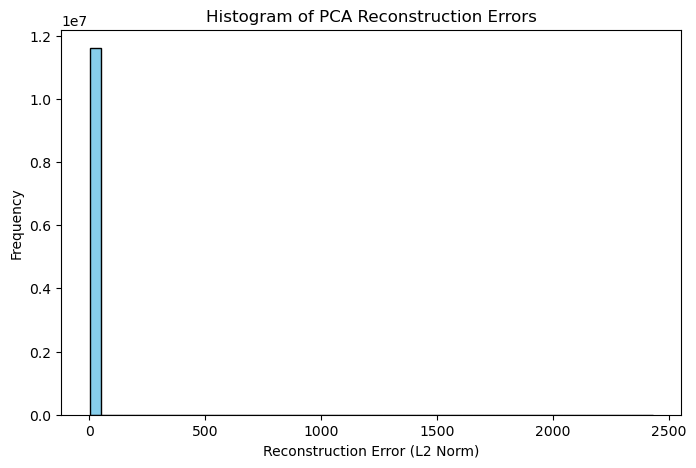

In [5]:
# -------------------------------
# Step 2: Compute the reconstruction error for each sample
# -------------------------------

# Here, we use the L2 norm (Euclidean distance) between the original and reconstructed sample.
# You can also use mean absolute error or squared error if preferred.
reconstruction_error = np.linalg.norm(scaled_data - reconstructed_data, axis=1)

# Plot a histogram of reconstruction errors for visual inspection
plt.figure(figsize=(8, 5))
plt.hist(reconstruction_error, bins=50, color='skyblue', edgecolor='k')
plt.xlabel('Reconstruction Error (L2 Norm)')
plt.ylabel('Frequency')
plt.title('Histogram of PCA Reconstruction Errors')
plt.show()

In [9]:
# -------------------------------
# Step 3: Define a threshold and label outliers
# -------------------------------

# Tunable Parameter 2: Threshold for flagging outliers.
#   Option A: Based on a fixed percentile (e.g., 95th percentile)
threshold = np.percentile(reconstruction_error, 99)

#   Option B: Based on mean + k * std (uncomment the next two lines to try this alternative)
# k = 2.0  # <-- Tune this multiplier based on your data
# threshold = reconstruction_error.mean() + k * reconstruction_error.std()

# Create an array of outlier labels.
#   Here we choose: -1 for outliers (error > threshold) and +1 for inliers.
outlier_labels = np.where(reconstruction_error > threshold, -1, 1)

# -------------------------------
# Step 4: Analyze & Report the Results
# -------------------------------

# Print out a few analytics about the reconstruction errors and classifications.
num_samples = len(reconstruction_error)
num_outliers = np.sum(outlier_labels == -1)
num_inliers = np.sum(outlier_labels == 1)

print("=== PCA-Based Outlier Detection Analytics ===")
print(f"Total samples: {num_samples}")
print(f"Number of inliers: {num_inliers} ({num_inliers / num_samples:.2%})")
print(f"Number of outliers: {num_outliers} ({num_outliers / num_samples:.2%})")
print(f"Threshold for outliers (reconstruction error): {threshold:.4f}")
print("\nTunable Parameters:")
print("- n_components: Number of principal components to keep for reconstruction.")
print("- Threshold method: Currently using the 95th percentile of reconstruction error.")
print("  (Alternatively, consider mean + k*std with k tunable.)")
print("- Reconstruction error metric: Using the L2 norm; alternatives include MAE or MSE.")

=== PCA-Based Outlier Detection Analytics ===
Total samples: 11607187
Number of inliers: 11491115 (99.00%)
Number of outliers: 116072 (1.00%)
Threshold for outliers (reconstruction error): 13.2900

Tunable Parameters:
- n_components: Number of principal components to keep for reconstruction.
- Threshold method: Currently using the 95th percentile of reconstruction error.
  (Alternatively, consider mean + k*std with k tunable.)
- Reconstruction error metric: Using the L2 norm; alternatives include MAE or MSE.


In [10]:
# -------------------------------
# (Optional) Step 5: Map Results Back to a DataFrame for Further Analysis or Graphing
# -------------------------------

# If you want to preserve the classification with your original data, you can add a new column.
# (Assuming that 'scaled_data' originated from a DataFrame with the same index, e.g., raw_df.)
results_df = pd.DataFrame(raw_df.copy())
results_df['Reconstruction_Error'] = reconstruction_error
results_df['Outlier_Label'] = outlier_labels
print("Mapped reconstruction error & outlier labels back to raw dataset.")

# For example, if you have a raw dataset (raw_df) with key features (say, 'RH_50' and 'RH_95'),
# and it shares the same index as scaled_data, you could merge the outlier labels back:
# raw_df['Outlier_Label'] = outlier_labels

# You can now use results_df (or raw_df) for further analysis or visualization.

Mapped reconstruction error & outlier labels back to raw dataset.


/users/jzhu118/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


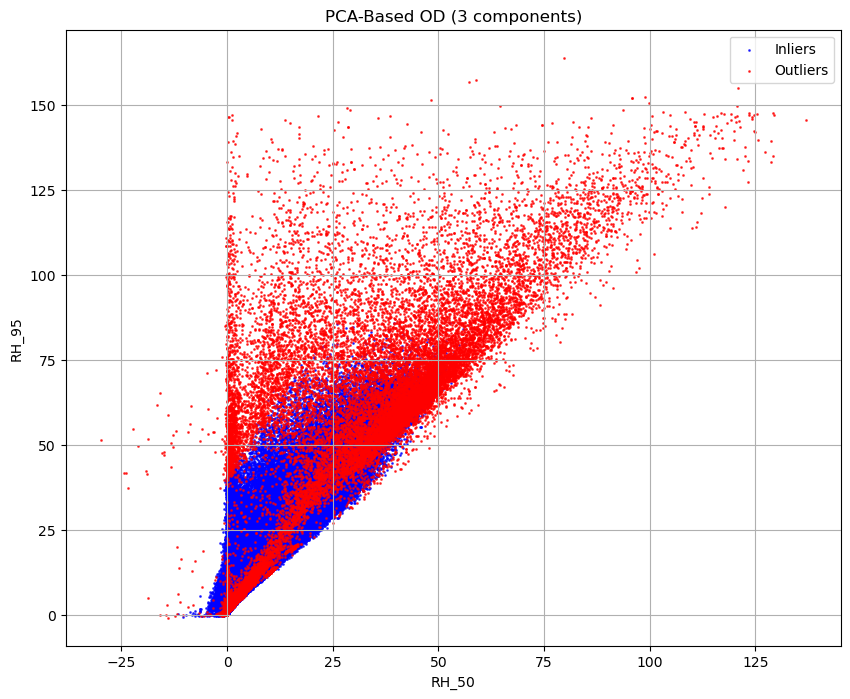

In [11]:
plt.figure(figsize=(10, 8))

# Plot inliers (assuming label +1) in blue
plt.scatter(results_df.loc[results_df['Outlier_Label'] == 1, 'RH_50'],
            results_df.loc[results_df['Outlier_Label'] == 1, 'RH_95'],
            s = 1,
            color='blue', label='Inliers', alpha=0.7)

# Plot outliers (assuming label -1) in red
plt.scatter(results_df.loc[results_df['Outlier_Label'] == -1, 'RH_50'],
            results_df.loc[results_df['Outlier_Label'] == -1, 'RH_95'],
            s = 1,
            color='red', label='Outliers', alpha=0.7)

plt.xlabel('RH_50')
plt.ylabel('RH_95')
plt.title('PCA-Based OD (3 components)')
plt.legend()
plt.grid(True)
plt.show()